In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time
import numpy as np

import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from cleverhans.utils_tf import batch_eval

from utils_config import ModelConfig, dataset_loader
from utils_experiment import get_data_dict
from utils_experiment import train_model
from utils_experiment import hyperparameter_selection
from dknn import DkNNModel, NearestNeighbor

In [11]:
mc = ModelConfig(config_file='../configs/config_mnist.yaml',
                 root_dir='../results/')

In [12]:
train_model(mc)

/Users/nicholasroberts/anaconda3/envs/gdknn/lib/python3.6/site-packages/cleverhans/utils_tf.py:511: UserWarning: No GPUS, running on CPU
  warnings.warn("No GPUS, running on CPU")


num_devices:  1


[INFO 2019-11-29 16:37:52,194 cleverhans] Epoch 0 took 15.373950958251953 seconds


Test accuracy: 0.8760


[INFO 2019-11-29 16:38:09,255 cleverhans] Epoch 1 took 14.593560934066772 seconds


Test accuracy: 0.9120


[INFO 2019-11-29 16:38:26,077 cleverhans] Epoch 2 took 14.459917068481445 seconds


Test accuracy: 0.8890


[INFO 2019-11-29 16:38:42,884 cleverhans] Epoch 3 took 14.483749866485596 seconds


Test accuracy: 0.8870


[INFO 2019-11-29 16:38:59,869 cleverhans] Epoch 4 took 14.641960859298706 seconds


Test accuracy: 0.8940


[INFO 2019-11-29 16:39:16,674 cleverhans] Epoch 5 took 14.451730251312256 seconds


Test accuracy: 0.9420


In [55]:
# reand and wrangle data
data_dict = get_data_dict(mc)

# parse data_dict
x_train = data_dict['x_train'] 
labels_train = data_dict['labels_train']
x_test = data_dict['x_test']
y_test = data_dict['y_test']
x_cali = data_dict['x_cali'] 
labels_cali = data_dict['labels_cali']

# Use Image Parameters.
img_rows, img_cols, nchannels = x_train.shape[1:4]

knns, knns_labels = {}, {}
knns_g, knns_g_labels = {}, {}

with mc.get_tensorflow_session() as sess:
    with tf.variable_scope('dknn'):
        # Instantiate model
        model_dir = mc.get_model_dir_name()
        model = mc.load_model(model_dir=model_dir)

        # Extract representations for the training and calibration data at each layer of interest to the DkNN.
        layers = ['ReLU1', 'ReLU3', 'ReLU5', 'logits']
        #layers = ['Input0', 'Conv2D1', 'Flatten2', 'logits']
        
        #Euclidean DKNN
        dknn = DkNNModel(
            sess = sess,
            model = model,
            neighbors = mc.nb_neighbors,
            proto_neighbors = mc.nb_proto_neighbors,
            img_rows=mc.img_rows,
            img_cols=mc.img_cols,
            backend=mc.backend,
            nchannels=mc.nchannels,
            nb_classes=mc.nb_classes,
            layers=layers,
            train_data=x_train,
            train_labels=labels_train,
            method='euclidean',
            neighbors_table_path=mc.get_model_dir_name(),
            scope='dknn')
        
        start = time.time()
        dknn.fit()
        end = time.time()
        print(end-start)
                
        dknn.calibrate(x_cali, labels_cali)
        preds_knn, _, _ = dknn.predict(x_test)

        # Geodesic DKNN
        dknn_geod = DkNNModel(
            sess = sess,
            model = model,
            neighbors = mc.nb_neighbors,
            proto_neighbors = mc.nb_proto_neighbors,
            img_rows=mc.img_rows,
            img_cols=mc.img_cols,
            backend=mc.backend,
            nchannels=mc.nchannels,
            nb_classes=mc.nb_classes,
            layers=layers,
            train_data=x_train,
            train_labels=labels_train,
            method='geodesic',
            neighbors_table_path=mc.get_model_dir_name(),
            scope='dknn')

        start = time.time()
        dknn_geod.fit()
        end = time.time()
        print(end-start)
        
        dknn_geod.calibrate(x_cali, labels_cali)
        preds_geod, _, _ = dknn_geod.predict(x_test)
        
        
        # Get activations for sample point
        data_activations = dknn.get_activations(x_test[30][np.newaxis, :])
        knns, knns_labels = dknn.find_train_knns(data_activations)
        
        data_activations_g = dknn_geod.get_activations(x_test[30][np.newaxis, :])
        knns_g, knns_g_labels = dknn_geod.find_train_knns(data_activations_g)
        

Loading model from:
 ../results/MNIST/nb_train_1000_lr_0.001_bs_2_1/model.joblib

Constructing the NearestNeighbor table layer ReLU1
Constructing the NearestNeighbor table layer ReLU3
Constructing the NearestNeighbor table layer ReLU5
Constructing the NearestNeighbor table layer logits
27.496877193450928
Starting calibration.
Completed calibration.

Constructing the GeodesicNearestNeighbor table layer ReLU1
Constructing the GeodesicNearestNeighbor table layer ReLU3
Constructing the GeodesicNearestNeighbor table layer ReLU5
Constructing the GeodesicNearestNeighbor table layer logits
0.39830994606018066
Starting calibration.
Completed calibration.



In [56]:
print((preds_knn==np.argmax(y_test,axis=1)).mean())
print((preds_geod==np.argmax(y_test,axis=1)).mean())

0.4
0.936


In [15]:
np.argmax(y_test,axis=1)

array([0, 5, 4, 3, 1, 1, 7, 4, 9, 9, 4, 8, 4, 0, 2, 4, 5, 1, 1, 6, 4, 7,
       1, 9, 4, 2, 4, 1, 5, 5, 3, 8, 3, 1, 4, 5, 6, 8, 9, 4, 1, 5, 3, 8,
       0, 3, 2, 5, 1, 2, 8, 3, 4, 4, 0, 8, 8, 3, 3, 1, 7, 3, 5, 9, 6, 3,
       2, 6, 1, 3, 6, 0, 7, 2, 1, 7, 1, 4, 2, 4, 2, 1, 7, 9, 6, 1, 1, 2,
       4, 8, 1, 7, 7, 4, 8, 0, 7, 3, 1, 3, 1, 0, 7, 7, 0, 3, 5, 5, 2, 7,
       6, 6, 9, 2, 8, 3, 5, 2, 2, 5, 6, 0, 8, 2, 9, 2, 8, 8, 8, 8, 7, 4,
       9, 3, 0, 6, 6, 3, 2, 1, 3, 2, 2, 9, 3, 0, 0, 5, 7, 8, 1, 4, 4, 6,
       0, 2, 9, 1, 4, 7, 4, 7, 3, 9, 8, 8, 4, 7, 1, 2, 1, 2, 2, 3, 2, 3,
       2, 3, 9, 1, 7, 4, 0, 3, 5, 5, 8, 6, 3, 2, 6, 7, 6, 6, 3, 2, 7, 8,
       1, 1, 7, 5, 6, 4, 9, 5, 1, 3, 3, 4, 7, 8, 9, 1, 1, 6, 9, 1, 4, 4,
       5, 4, 0, 6, 2, 2, 3, 1, 5, 1, 2, 0, 3, 8, 1, 2, 6, 7, 1, 6, 2, 3,
       9, 0, 1, 2, 2, 0, 8, 9])

In [9]:
dknn_geod.train_activations['ReLU3']

array([[-1.5092314e-03, -2.8760508e-03, -8.2429338e-05, ...,
        -2.8867761e-03, -1.2071506e-02, -1.7074790e-02],
       [-1.5092314e-03, -2.8760508e-03, -8.2429338e-05, ...,
        -2.9685991e-03, -1.2071506e-02, -1.7074790e-02],
       [ 9.4541768e-03, -2.8760508e-03, -8.2429338e-05, ...,
        -2.9685991e-03, -1.2071506e-02, -1.7074790e-02],
       ...,
       [-1.5092314e-03,  2.0107185e-04, -8.2429338e-05, ...,
        -2.9685991e-03, -1.2071506e-02, -2.9263124e-03],
       [-1.5092314e-03, -2.8760508e-03, -8.2429338e-05, ...,
        -2.9685991e-03, -1.2071506e-02, -1.7074790e-02],
       [-1.5092314e-03,  3.5749476e-02, -8.2429338e-05, ...,
        -4.1867560e-04, -1.1427046e-02,  2.3924865e-02]], dtype=float32)

In [25]:
preds_geod

array([0, 5, 4, 3, 1, 1, 7, 4, 9, 9, 9, 8, 4, 0, 2, 4, 5, 1, 1, 6, 4, 7,
       1, 9, 4, 2, 4, 1, 5, 5, 3, 8, 3, 1, 4, 5, 6, 8, 9, 4, 1, 5, 3, 8,
       0, 3, 2, 5, 1, 2, 5, 3, 4, 4, 0, 8, 8, 3, 3, 1, 2, 3, 5, 9, 6, 3,
       2, 6, 1, 3, 6, 0, 7, 2, 1, 7, 1, 4, 2, 4, 2, 1, 7, 9, 6, 1, 1, 2,
       4, 0, 1, 7, 7, 4, 7, 0, 7, 3, 1, 3, 1, 0, 7, 7, 0, 3, 5, 5, 2, 7,
       6, 6, 9, 2, 8, 3, 5, 2, 2, 5, 6, 0, 8, 2, 9, 2, 8, 8, 8, 8, 7, 9,
       9, 3, 0, 6, 6, 3, 2, 1, 3, 2, 2, 9, 3, 0, 0, 5, 7, 8, 1, 4, 4, 6,
       0, 2, 9, 1, 4, 7, 4, 7, 3, 9, 8, 8, 4, 7, 1, 2, 1, 2, 2, 3, 7, 3,
       8, 3, 9, 1, 7, 4, 0, 3, 5, 5, 8, 6, 5, 0, 6, 7, 6, 6, 3, 2, 7, 9,
       1, 1, 2, 5, 6, 4, 9, 5, 1, 3, 3, 9, 9, 8, 9, 1, 1, 0, 9, 1, 4, 4,
       5, 4, 0, 6, 2, 2, 3, 1, 5, 1, 2, 0, 2, 8, 1, 2, 6, 7, 1, 6, 2, 3,
       9, 0, 1, 2, 2, 0, 8, 9], dtype=int32)

In [69]:
import matplotlib
import matplotlib.pyplot as plt

In [24]:

preds_geod, _, _ = dknn_geod.predict(x_test)
dknn_geod.find_train_knns(preds_geod)

<bound method DkNNModel.find_train_knns of <dknn.DkNNModel object at 0x14b532748>>

In [157]:
knns_g

{'ReLU1': array([[ 12, 298, 752, 392, 874, 490, 486, 136, 149,  74,  98, 198, 924,
         356, 284, 404, 866, 875, 760, 316,  86, 228,  27, 748, 620, 890,
         332, 130, 970, 975, 215,  48,  50, 856, 266, 767, 504, 242, 675,
         386, 840, 992,  49,  10, 736, 479, 628, 330, 956, 808, 886, 602,
         254, 111,  25, 244, 544, 830, 998, 546, 352, 182, 134,  28,  76,
         740, 495, 983, 895, 502, 512, 554, 452, 726, 862,  30, 252, 953,
          44, 333, 722, 458, 792, 878, 360, 588, 516, 246, 540, 643, 734,
         530, 974, 668, 140, 984, 144, 966, 718, 312, 532, 235, 444, 789,
           7, 321, 291, 179, 424, 107, 909, 341, 361, 433, 695, 255, 135,
         715, 557, 861, 279, 281, 203, 549, 719, 405, 811, 731]],
       dtype=int32),
 'ReLU3': array([[490, 975,  50, 874, 675, 992, 767, 215, 254, 909,  49, 495,  10,
          12, 298, 546, 242, 840, 330, 748, 970, 452, 998, 789, 235, 433,
         695, 715, 321, 861, 811, 731, 281, 255, 291, 867, 643, 479, 107,
       

In [52]:
np.argmax(y_test[30])

3

In [151]:
np.random.seed(0)

#samples_knn = np.random.choice(np.nonzero(knns['ReLU3'][0])[0], 9, replace=False)
#samples_gknn = np.random.choice(np.nonzero(knns_g['ReLU3'][0])[0], 9, replace=False)


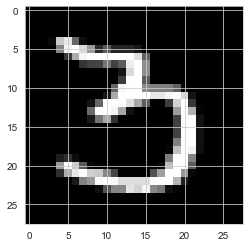

In [152]:
plt.imshow(x_test[30][np.newaxis, :][0, :, :, 0])
plt.show()

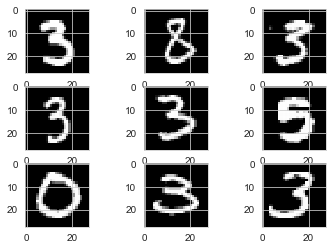

In [153]:
plt.gray()

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[knns['ReLU3'][0][samples_knn[i]], :, :, 0])
    
plt.show()

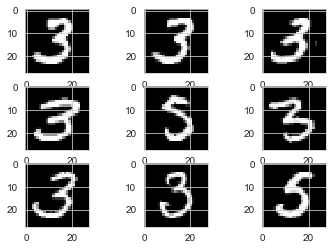

In [154]:
plt.gray()

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[knns_g['ReLU3'][0][samples_gknn[i]], :, :, 0])
    
plt.show()